In [1]:
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

2024-03-18 16:05:01.700486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 16:05:01.700605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 16:05:01.790520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers"
data_dir = pathlib.Path(data_dir)
print(data_dir)

test_data_dir = "/kaggle/input/testingdataset/TestingDataset_PP"
test_data_dir = pathlib.Path(test_data_dir)
print(test_data_dir)

/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers
/kaggle/input/testingdataset/TestingDataset_PP


/kaggle/input/handwritten-marathi-character-augmented-dataset/Numbers/C58/C58_94_augmented_0.jpg


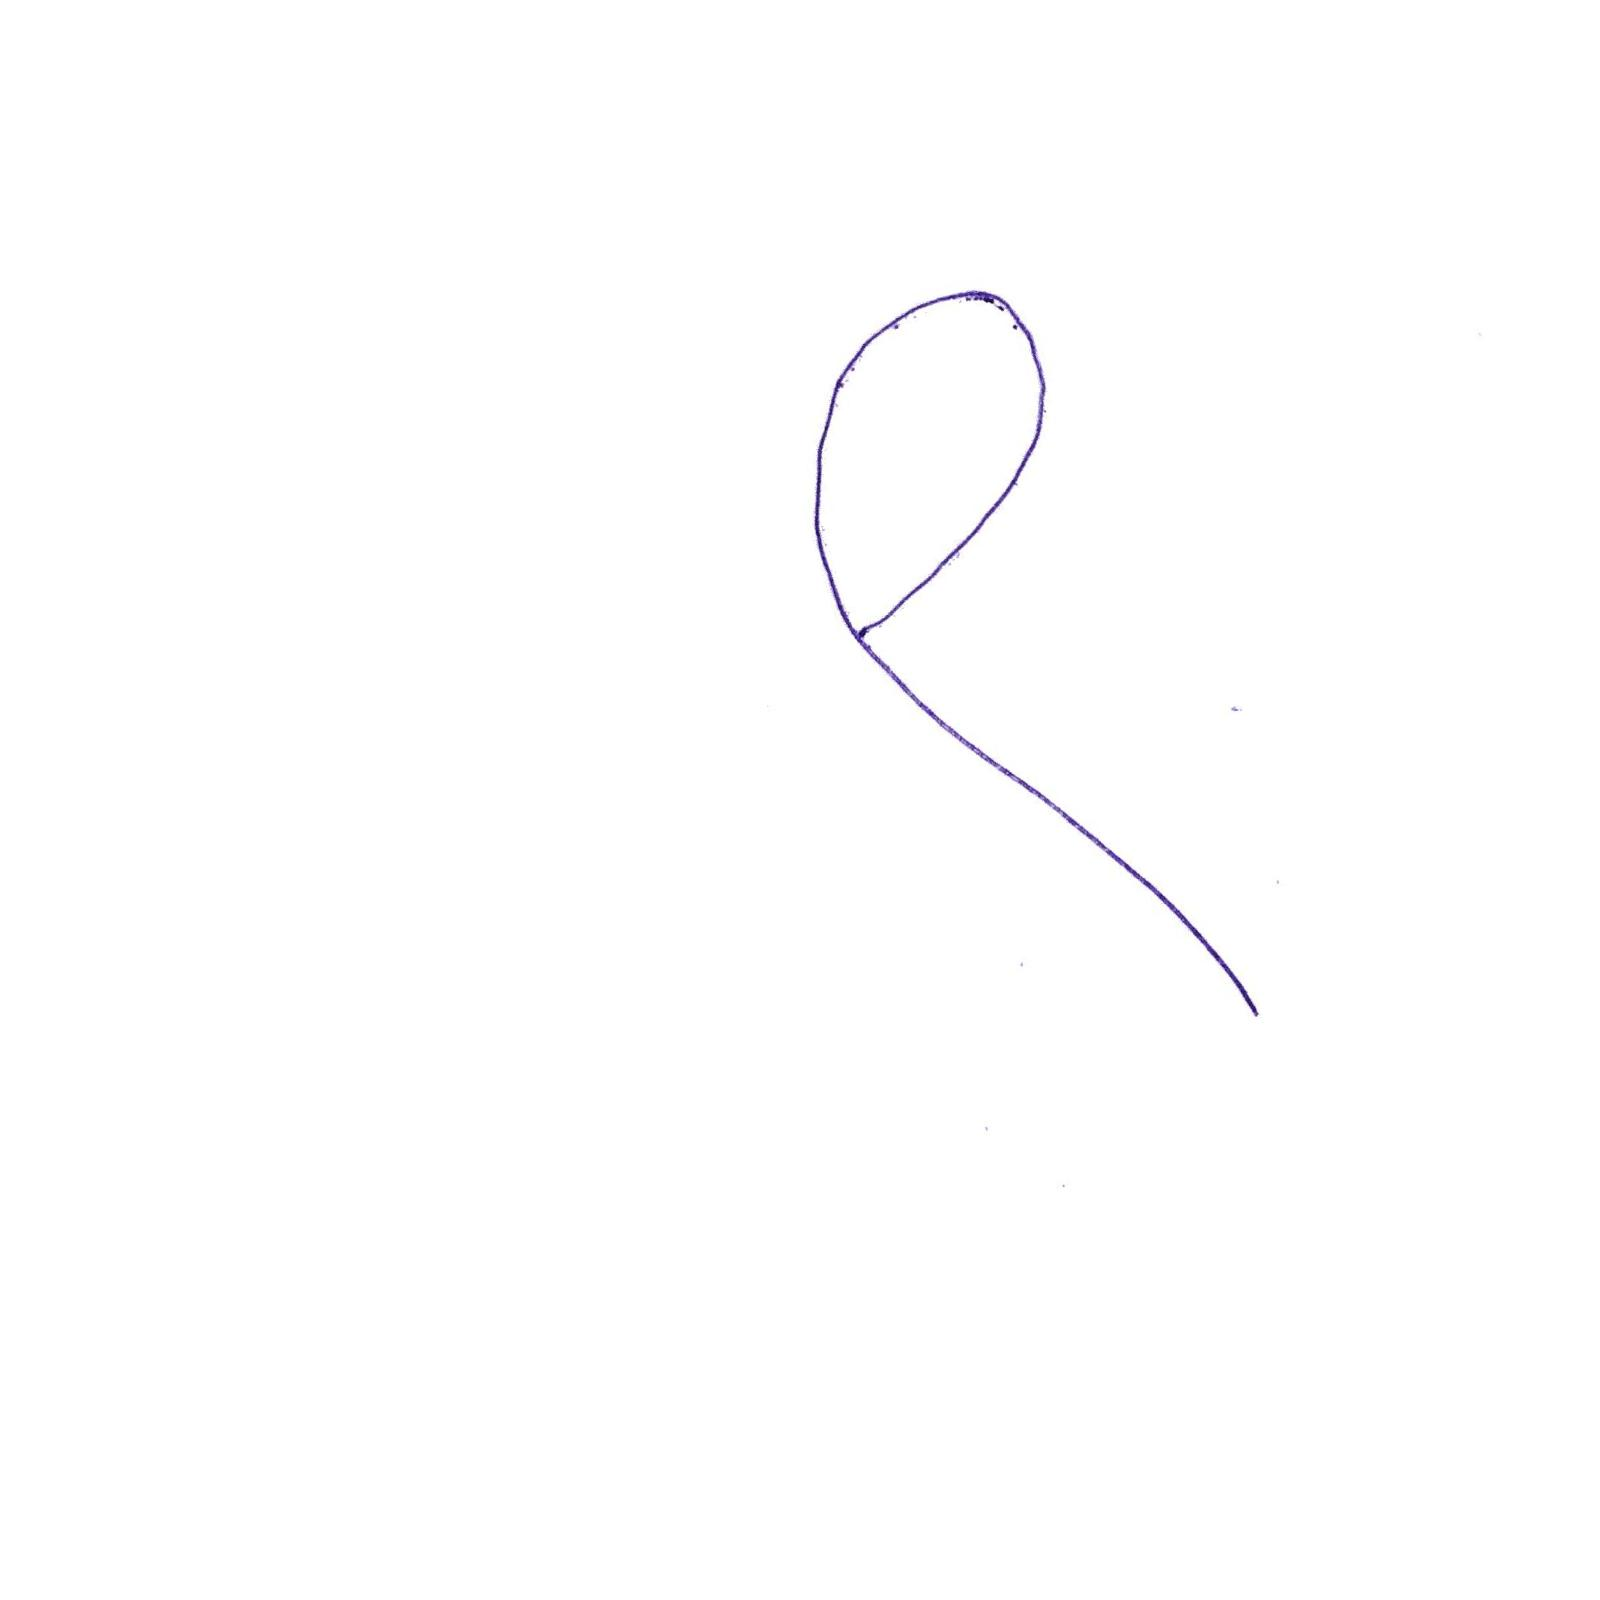

In [3]:
ch1 = list(data_dir.glob('C58/*'))
print(ch1[0])
PIL.Image.open(str(ch1[0]))

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height,img_width=224,224
batch_size = 32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
    channel_shift_range=50,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

# Prepare training dataset with data augmentation
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Prepare validation dataset without data augmentation
val_ds = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

# Prepare Testing dataset without data augmentation
test_ds = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=123
)

Found 4800 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


In [5]:
class_indices = train_ds.class_indices
class_names = {v: k for k, v in class_indices.items()}
print(class_names)

{0: 'C49', 1: 'C50', 2: 'C51', 3: 'C52', 4: 'C53', 5: 'C54', 6: 'C55', 7: 'C56', 8: 'C57', 9: 'C58'}


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten


# Load VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(train_ds.class_indices), activation="softmax")
])


model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [7]:
# creating checkpoints
model_path_acc = "/kaggle/working/MNCR_best_model_M1_V2_Acc.h5"
model_path_loss = "/kaggle/working/MNCR_best_model_M1_V2_Loss.h5"

# Define the checkpoints
checkpoint_acc = ModelCheckpoint(model_path_acc, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
checkpoint_loss = ModelCheckpoint(model_path_loss, monitor="val_loss", verbose=1, save_best_only=True, mode="min")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint_acc,checkpoint_loss]  
)

Epoch 1/50


I0000 00:00:1710777932.025831      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 [==============================] - ETA: 0s - loss: 2.8327 - accuracy: 0.1423
Epoch 1: val_accuracy improved from -inf to 0.10417, saving model to /kaggle/working/MNCR_best_model_M1_V2_Acc.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_loss improved from inf to 2.38708, saving model to /kaggle/working/MNCR_best_model_M1_V2_Loss.h5
150/150 [==============================] - 134s 752ms/step - loss: 2.8327 - accuracy: 0.1423 - val_loss: 2.3871 - val_accuracy: 0.1042
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 2.2874 - accuracy: 0.2488
Epoch 2: val_accuracy improved from 0.10417 to 0.18667, saving model to /kaggle/working/MNCR_best_model_M1_V2_Acc.h5

Epoch 2: val_loss improved from 2.38708 to 2.20967, saving model to /kaggle/working/MNCR_best_model_M1_V2_Loss.h5
150/150 [==============================] - 63s 419ms/step - loss: 2.2874 - accuracy: 0.2488 - val_loss: 2.2097 - val_accuracy: 0.1867
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 2.0041 - accuracy: 0.3146
Epoch 3: val_accuracy improved from 0.18667 to 0.48000, saving model to /kaggle/working/MNCR_best_model_M1_V2_Acc.h5

Epoch 3: val_loss improved from 2.20967 to 1.73508, saving model to /kaggle/wo

In [8]:
from tensorflow.keras.models import load_model
best_model1 = load_model('/kaggle/working/MNCR_best_model_M1_V2_Acc.h5')

# best model1
val_loss, val_accuracy = best_model1.evaluate(test_ds)
print(f"Testing Loss: {val_loss}")
print(f"Testing Accuracy: {val_accuracy}")

13/13 [==============================] - 3s 205ms/step - loss: 0.5489 - accuracy: 0.8725
Testing Loss: 0.5488872528076172
Testing Accuracy: 0.8725000023841858


In [9]:
best_model2 = load_model('/kaggle/working/MNCR_best_model_M1_V2_Loss.h5')

In [10]:
# Best model2
val_loss, val_accuracy = best_model2.evaluate(test_ds)
print(f"Testing Loss: {val_loss}")
print(f"Testing Accuracy: {val_accuracy}")

13/13 [==============================] - 2s 93ms/step - loss: 0.4724 - accuracy: 0.8875
Testing Loss: 0.4724215567111969
Testing Accuracy: 0.887499988079071
